[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/danpele/Time-Series-Analysis/blob/main/chapter2_lecture_notebook.ipynb)

---

# Chapter 2: ARMA Models

**Course:** Time Series Analysis and Forecasting  
**Program:** Bachelor program, Faculty of Cybernetics, Statistics and Economic Informatics, Bucharest University of Economic Studies, Romania  
**Academic Year:** 2025-2026

---

## Learning Objectives

By the end of this notebook, you will be able to:
1. Understand and simulate AR, MA, and ARMA processes
2. Identify model orders using ACF and PACF
3. Estimate ARMA parameters using Maximum Likelihood
4. Perform model diagnostics (residual analysis, Ljung-Box test)
5. Generate forecasts with confidence intervals
6. Compare models using information criteria (AIC, BIC)

## Setup and Imports

In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Time series specific
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy import stats

# Plotting style - clean, professional
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['savefig.facecolor'] = 'none'
plt.rcParams['savefig.transparent'] = True
plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.grid'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# Colors (IDA color scheme)
COLORS = {
    'blue': '#1A3A6E',
    'red': '#DC3545',
    'green': '#2E7D32',
    'orange': '#E67E22',
    'gray': '#666666'
}

print("All libraries loaded successfully!")

All libraries loaded successfully!


## 1. The Lag Operator

The **lag operator** (or backshift operator) $L$ shifts a time series back by one period:

$$L X_t = X_{t-1}$$

**Properties:**
- $L^k X_t = X_{t-k}$
- $(1-L)X_t = X_t - X_{t-1} = \Delta X_t$ (first difference)

In [2]:
# Demonstrate lag operator
np.random.seed(42)
X = pd.Series([10, 12, 15, 14, 18, 20, 19, 22], name='X_t')

# Create lagged versions
df = pd.DataFrame({
    'X_t': X,
    'L(X_t) = X_{t-1}': X.shift(1),
    'L^2(X_t) = X_{t-2}': X.shift(2),
    '(1-L)X_t = ΔX_t': X.diff(1)
})

print("Lag Operator Examples:")
print(df.to_string())

Lag Operator Examples:
   X_t  L(X_t) = X_{t-1}  L^2(X_t) = X_{t-2}  (1-L)X_t = ΔX_t
0   10               NaN                 NaN              NaN
1   12              10.0                 NaN              2.0
2   15              12.0                10.0              3.0
3   14              15.0                12.0             -1.0
4   18              14.0                15.0              4.0
5   20              18.0                14.0              2.0
6   19              20.0                18.0             -1.0
7   22              19.0                20.0              3.0


## 2. Autoregressive (AR) Models

### AR(1) Model

$$X_t = c + \phi X_{t-1} + \varepsilon_t$$

where $\varepsilon_t \sim WN(0, \sigma^2)$.

**Stationarity condition:** $|\phi| < 1$

**Properties:**
- Mean: $\mu = \frac{c}{1-\phi}$
- Variance: $\gamma(0) = \frac{\sigma^2}{1-\phi^2}$
- ACF: $\rho(h) = \phi^h$ (exponential decay)

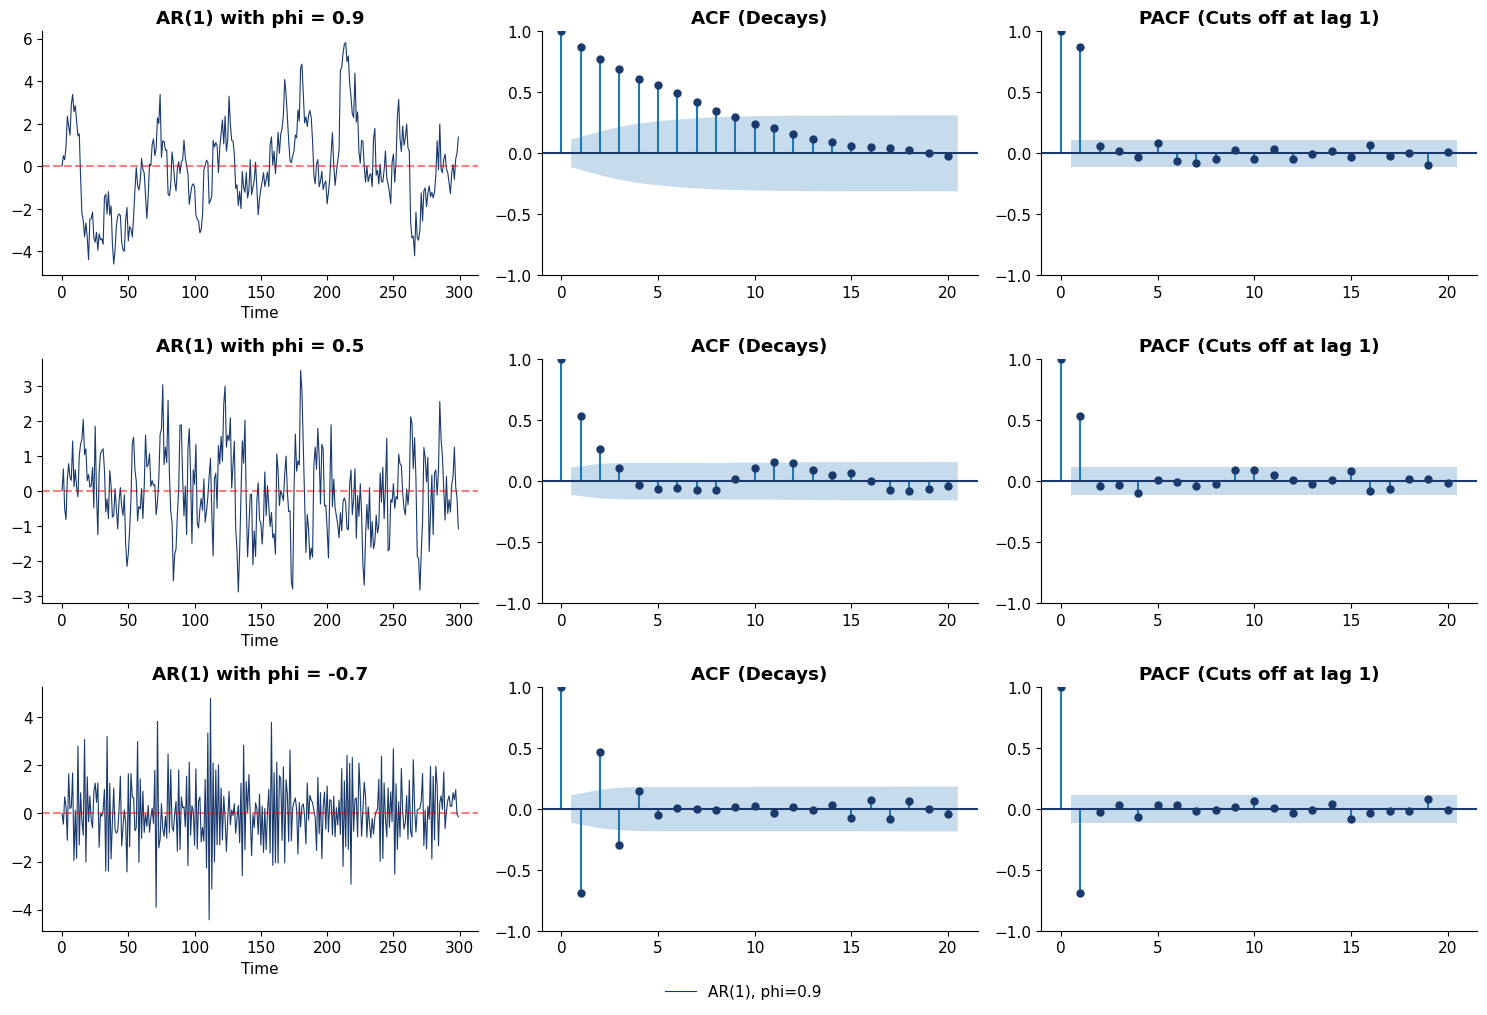

In [3]:
# Simulate AR(1) processes with different phi values
np.random.seed(42)
n = 300
phi_values = [0.9, 0.5, -0.7]

fig, axes = plt.subplots(len(phi_values), 3, figsize=(15, 10))

for i, phi in enumerate(phi_values):
    # Simulate AR(1)
    ar1 = np.zeros(n)
    for t in range(1, n):
        ar1[t] = phi * ar1[t-1] + np.random.randn()
    
    # Time series plot
    axes[i, 0].plot(ar1, color=COLORS['blue'], linewidth=0.8, label=f'AR(1), phi={phi}')
    axes[i, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes[i, 0].set_title(f'AR(1) with phi = {phi}', fontweight='bold')
    axes[i, 0].set_xlabel('Time')
    
    # ACF
    plot_acf(ar1, ax=axes[i, 1], lags=20, color=COLORS['blue'])
    axes[i, 1].set_title('ACF (Decays)', fontweight='bold')
    
    # PACF
    plot_pacf(ar1, ax=axes[i, 2], lags=20, color=COLORS['blue'], method='ywm')
    axes[i, 2].set_title('PACF (Cuts off at lag 1)', fontweight='bold')

# Collect legend from first row
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.02))
plt.subplots_adjust(bottom=0.08)
plt.tight_layout()
plt.show()

In [4]:
print("\nKey Pattern: AR(1) has exponentially decaying ACF and PACF that cuts off after lag 1")


Key Pattern: AR(1) has exponentially decaying ACF and PACF that cuts off after lag 1


### AR(2) Model

$$X_t = c + \phi_1 X_{t-1} + \phi_2 X_{t-2} + \varepsilon_t$$

**Stationarity conditions:**
1. $\phi_1 + \phi_2 < 1$
2. $\phi_2 - \phi_1 < 1$
3. $|\phi_2| < 1$

AR(2) can exhibit **pseudo-cyclical behavior** when roots are complex.

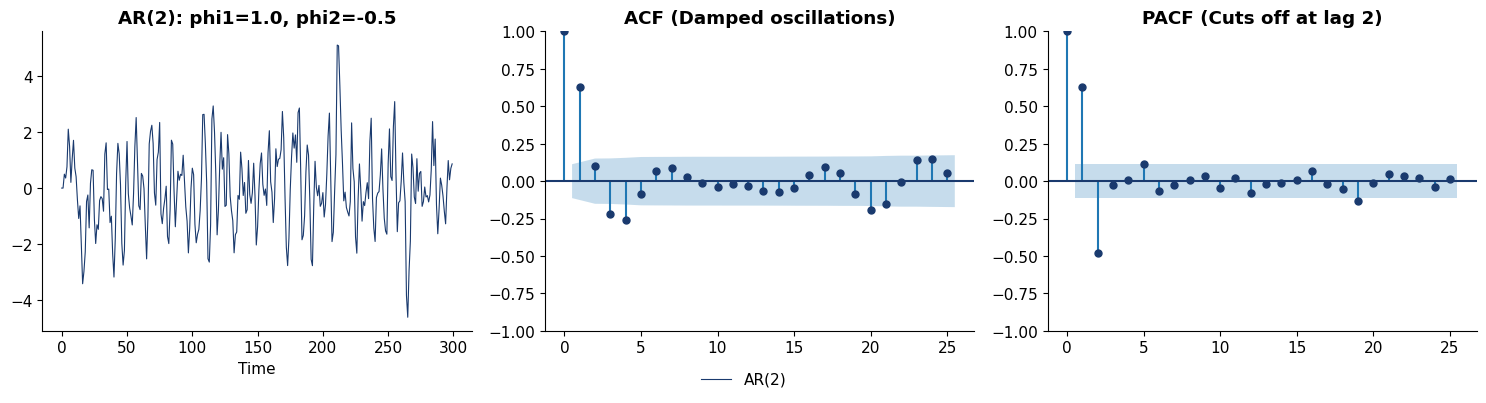

In [5]:
# Simulate AR(2) with complex roots (pseudo-cycles)
np.random.seed(42)
n = 300
phi1, phi2 = 1.0, -0.5  # Complex roots -> oscillations

ar2 = np.zeros(n)
for t in range(2, n):
    ar2[t] = phi1 * ar2[t-1] + phi2 * ar2[t-2] + np.random.randn()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Time series
line1, = axes[0].plot(ar2, color=COLORS['blue'], linewidth=0.8, label='AR(2)')
axes[0].set_title(f'AR(2): phi1={phi1}, phi2={phi2}', fontweight='bold')
axes[0].set_xlabel('Time')

# ACF
plot_acf(ar2, ax=axes[1], lags=25, color=COLORS['blue'])
axes[1].set_title('ACF (Damped oscillations)', fontweight='bold')

# PACF
plot_pacf(ar2, ax=axes[2], lags=25, color=COLORS['blue'], method='ywm')
axes[2].set_title('PACF (Cuts off at lag 2)', fontweight='bold')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=1, bbox_to_anchor=(0.5, -0.02))
plt.subplots_adjust(bottom=0.15)
plt.tight_layout()
plt.show()

In [6]:
# Check stationarity conditions
print(f"\nStationarity check for AR(2) with phi1={phi1}, phi2={phi2}:")
print(f"  phi1 + phi2 = {phi1 + phi2} < 1? {phi1 + phi2 < 1}")
print(f"  phi2 - phi1 = {phi2 - phi1} < 1? {phi2 - phi1 < 1}")
print(f"  |phi2| = {abs(phi2)} < 1? {abs(phi2) < 1}")


Stationarity check for AR(2) with phi1=1.0, phi2=-0.5:
  phi1 + phi2 = 0.5 < 1? True
  phi2 - phi1 = -1.5 < 1? True
  |phi2| = 0.5 < 1? True


## 3. Moving Average (MA) Models

### MA(1) Model

$$X_t = \mu + \varepsilon_t + \theta \varepsilon_{t-1}$$

**Properties:**
- Always stationary (for finite $\theta$)
- Invertible if $|\theta| < 1$
- ACF: $\rho(1) = \frac{\theta}{1+\theta^2}$, $\rho(h) = 0$ for $h > 1$

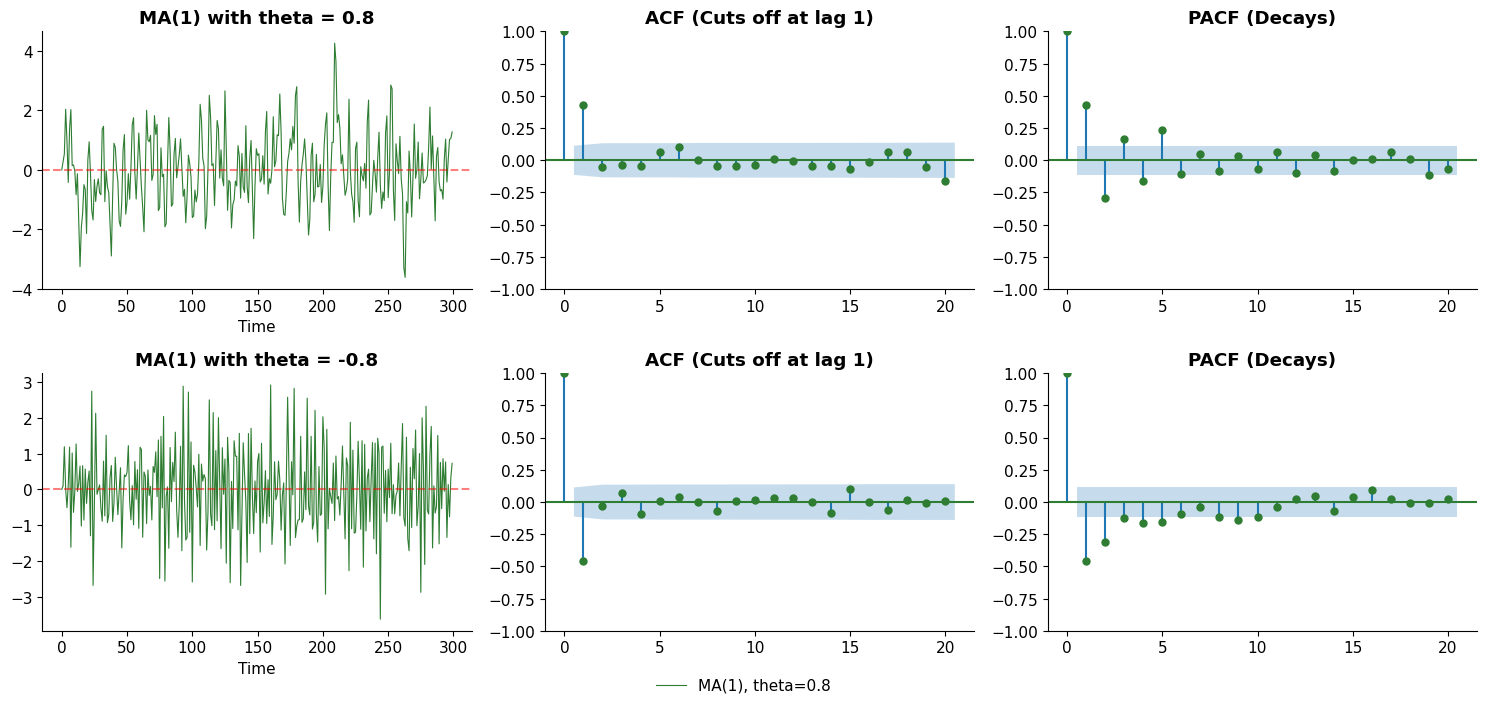

In [7]:
# Simulate MA(1) processes
np.random.seed(42)
n = 300
theta_values = [0.8, -0.8]

fig, axes = plt.subplots(len(theta_values), 3, figsize=(15, 7))

for i, theta in enumerate(theta_values):
    # Simulate MA(1)
    eps = np.random.randn(n)
    ma1 = np.zeros(n)
    for t in range(1, n):
        ma1[t] = eps[t] + theta * eps[t-1]
    
    # Time series plot
    axes[i, 0].plot(ma1, color=COLORS['green'], linewidth=0.8, label=f'MA(1), theta={theta}')
    axes[i, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes[i, 0].set_title(f'MA(1) with theta = {theta}', fontweight='bold')
    axes[i, 0].set_xlabel('Time')
    
    # ACF
    plot_acf(ma1, ax=axes[i, 1], lags=20, color=COLORS['green'])
    axes[i, 1].set_title('ACF (Cuts off at lag 1)', fontweight='bold')
    
    # PACF
    plot_pacf(ma1, ax=axes[i, 2], lags=20, color=COLORS['green'], method='ywm')
    axes[i, 2].set_title('PACF (Decays)', fontweight='bold')

# Collect handles and labels from first row only
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=1, bbox_to_anchor=(0.5, -0.02))
plt.subplots_adjust(bottom=0.1)
plt.tight_layout()
plt.show()

In [8]:
# Theoretical ACF for MA(1)
for theta in theta_values:
    rho1 = theta / (1 + theta**2)
    print(f"MA(1) theta={theta}: Theoretical rho(1) = {rho1:.4f}")

MA(1) theta=0.8: Theoretical rho(1) = 0.4878
MA(1) theta=-0.8: Theoretical rho(1) = -0.4878


## 4. ARMA Models

### ARMA(p,q) Model

$$X_t = c + \phi_1 X_{t-1} + \cdots + \phi_p X_{t-p} + \varepsilon_t + \theta_1\varepsilon_{t-1} + \cdots + \theta_q\varepsilon_{t-q}$$

**Compact form:** $\phi(L)X_t = c + \theta(L)\varepsilon_t$

**Key pattern:** Both ACF and PACF decay (neither cuts off cleanly)

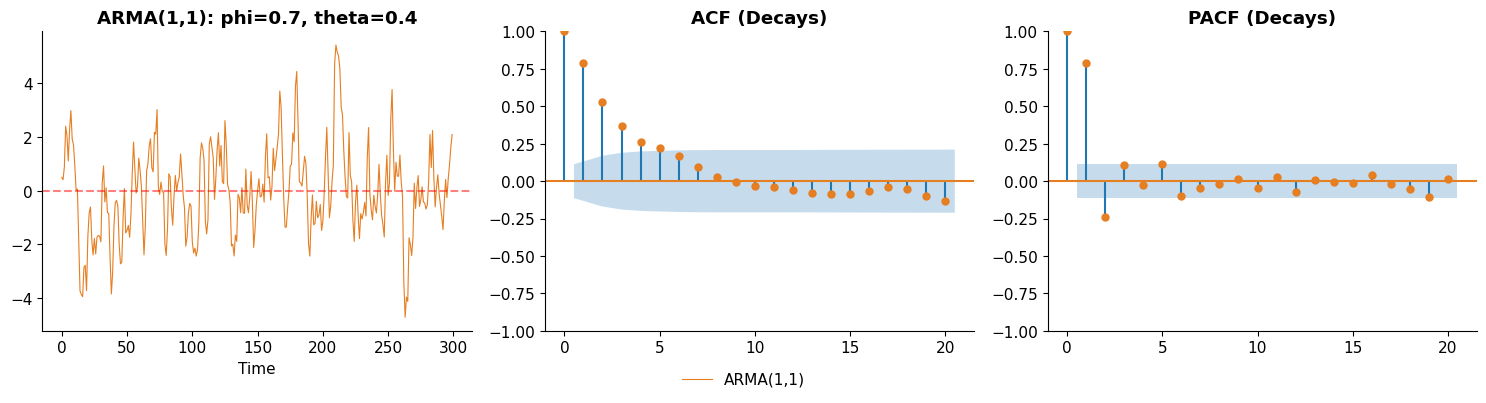

In [9]:
# Simulate ARMA(1,1)
np.random.seed(42)
n = 300
phi, theta = 0.7, 0.4

# Use statsmodels ArmaProcess for correct simulation
ar_coef = np.array([1, -phi])  # AR polynomial: 1 - phi*L
ma_coef = np.array([1, theta])  # MA polynomial: 1 + theta*L
arma_process = ArmaProcess(ar_coef, ma_coef)
arma11 = arma_process.generate_sample(n)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Time series
axes[0].plot(arma11, color=COLORS['orange'], linewidth=0.8, label='ARMA(1,1)')
axes[0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0].set_title(f'ARMA(1,1): phi={phi}, theta={theta}', fontweight='bold')
axes[0].set_xlabel('Time')

# ACF
plot_acf(arma11, ax=axes[1], lags=20, color=COLORS['orange'])
axes[1].set_title('ACF (Decays)', fontweight='bold')

# PACF
plot_pacf(arma11, ax=axes[2], lags=20, color=COLORS['orange'], method='ywm')
axes[2].set_title('PACF (Decays)', fontweight='bold')

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=1, bbox_to_anchor=(0.5, -0.02))
plt.subplots_adjust(bottom=0.15)
plt.tight_layout()
plt.show()

In [10]:
print("\nARMA(p,q) Identification: Both ACF and PACF decay gradually")


ARMA(p,q) Identification: Both ACF and PACF decay gradually


## 5. Model Identification Summary

| Model | ACF Pattern | PACF Pattern |
|-------|-------------|---------------|
| AR(p) | Decays (exp. or damped) | Cuts off at lag p |
| MA(q) | Cuts off at lag q | Decays (exp. or damped) |
| ARMA(p,q) | Decays | Decays |

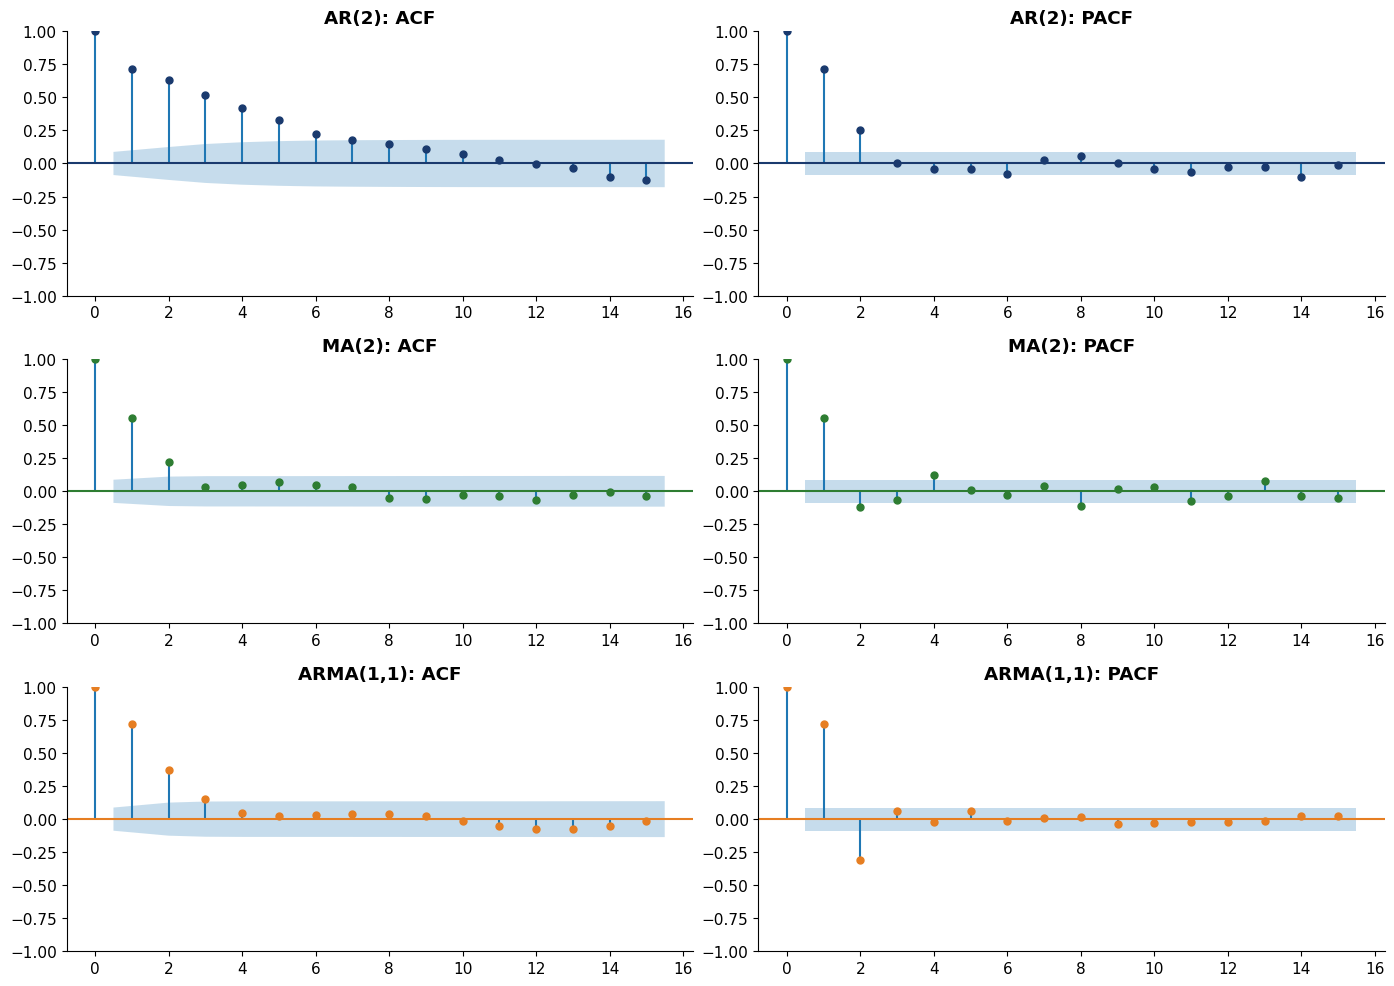

In [11]:
# Visual comparison of AR, MA, ARMA patterns
np.random.seed(123)
n = 500

# Simulate different processes
# AR(2)
ar2 = np.zeros(n)
for t in range(2, n):
    ar2[t] = 0.5*ar2[t-1] + 0.3*ar2[t-2] + np.random.randn()

# MA(2)
eps = np.random.randn(n)
ma2 = np.zeros(n)
for t in range(2, n):
    ma2[t] = eps[t] + 0.6*eps[t-1] + 0.3*eps[t-2]

# ARMA(1,1)
ar_coef = np.array([1, -0.6])
ma_coef = np.array([1, 0.4])
arma = ArmaProcess(ar_coef, ma_coef).generate_sample(n)

fig, axes = plt.subplots(3, 2, figsize=(14, 10))

processes = [
    (ar2, 'AR(2)', COLORS['blue']),
    (ma2, 'MA(2)', COLORS['green']),
    (arma, 'ARMA(1,1)', COLORS['orange'])
]

for i, (data, name, color) in enumerate(processes):
    plot_acf(data, ax=axes[i, 0], lags=15, color=color)
    axes[i, 0].set_title(f'{name}: ACF', fontweight='bold')
    
    plot_pacf(data, ax=axes[i, 1], lags=15, color=color, method='ywm')
    axes[i, 1].set_title(f'{name}: PACF', fontweight='bold')

plt.subplots_adjust(bottom=0.05)
plt.tight_layout()
plt.show()

In [12]:
print("Identification Guide:")
print("- AR(2): ACF decays, PACF cuts off at lag 2")
print("- MA(2): ACF cuts off at lag 2, PACF decays")
print("- ARMA(1,1): Both ACF and PACF decay")

Identification Guide:
- AR(2): ACF decays, PACF cuts off at lag 2
- MA(2): ACF cuts off at lag 2, PACF decays
- ARMA(1,1): Both ACF and PACF decay


## 6. Model Estimation

We use **Maximum Likelihood Estimation (MLE)** to fit ARMA models.

In [13]:
# Fit ARMA model to simulated data
# True model: AR(1) with phi = 0.7
np.random.seed(42)
n = 500
true_phi = 0.7

ar1_data = np.zeros(n)
for t in range(1, n):
    ar1_data[t] = true_phi * ar1_data[t-1] + np.random.randn()

# Fit AR(1) model using ARIMA with d=0
model = ARIMA(ar1_data, order=(1, 0, 0))
results = model.fit()

print("=" * 60)
print("AR(1) Model Estimation Results")
print("=" * 60)
print(f"True phi = {true_phi}")
print(f"Estimated phi = {results.arparams[0]:.4f}")
print(f"Standard Error = {results.bse[0]:.4f}")
print(f"95% CI: [{results.arparams[0] - 1.96*results.bse[0]:.4f}, {results.arparams[0] + 1.96*results.bse[0]:.4f}]")
print(f"\nAIC = {results.aic:.2f}")
print(f"BIC = {results.bic:.2f}")

AR(1) Model Estimation Results
True phi = 0.7
Estimated phi = 0.6836
Standard Error = 0.1397
95% CI: [0.4097, 0.9575]

AIC = 1403.42
BIC = 1416.06


In [14]:
# Model summary
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  500
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -698.708
Date:                Sun, 18 Jan 2026   AIC                           1403.415
Time:                        17:07:15   BIC                           1416.059
Sample:                             0   HQIC                          1408.377
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0321      0.140      0.229      0.819      -0.242       0.306
ar.L1          0.6836      0.033     20.871      0.000       0.619       0.748
sigma2         0.9567      0.057     16.740      0.0

## 7. Model Selection with Information Criteria

**AIC** (Akaike Information Criterion): $\text{AIC} = -2\ln(\hat{L}) + 2k$

**BIC** (Bayesian Information Criterion): $\text{BIC} = -2\ln(\hat{L}) + k\ln(n)$

Lower values are better. BIC penalizes complexity more strongly.

In [15]:
# Compare different model orders
orders = [(1,0,0), (2,0,0), (0,0,1), (0,0,2), (1,0,1), (2,0,1)]
results_dict = {}

print("Model Comparison:")
print("=" * 50)
print(f"{'Model':<15} {'AIC':>12} {'BIC':>12}")
print("-" * 50)

for order in orders:
    try:
        model = ARIMA(ar1_data, order=order)
        res = model.fit()
        model_name = f"ARMA({order[0]},{order[2]})"
        results_dict[model_name] = {'AIC': res.aic, 'BIC': res.bic}
        print(f"{model_name:<15} {res.aic:>12.2f} {res.bic:>12.2f}")
    except:
        pass

print("-" * 50)
print("\nBest model by AIC:", min(results_dict, key=lambda x: results_dict[x]['AIC']))
print("Best model by BIC:", min(results_dict, key=lambda x: results_dict[x]['BIC']))

Model Comparison:
Model                    AIC          BIC
--------------------------------------------------
ARMA(1,0)            1403.42      1416.06
ARMA(2,0)            1405.35      1422.21
ARMA(0,1)            1497.24      1509.88
ARMA(0,2)            1446.17      1463.03
ARMA(1,1)            1405.35      1422.21


ARMA(2,1)            1405.30      1426.37
--------------------------------------------------

Best model by AIC: ARMA(1,0)
Best model by BIC: ARMA(1,0)


/opt/anaconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## 8. Model Diagnostics

After fitting a model, we check if residuals are white noise:
1. Plot residuals over time
2. Check ACF of residuals
3. Ljung-Box test for autocorrelation
4. Q-Q plot for normality

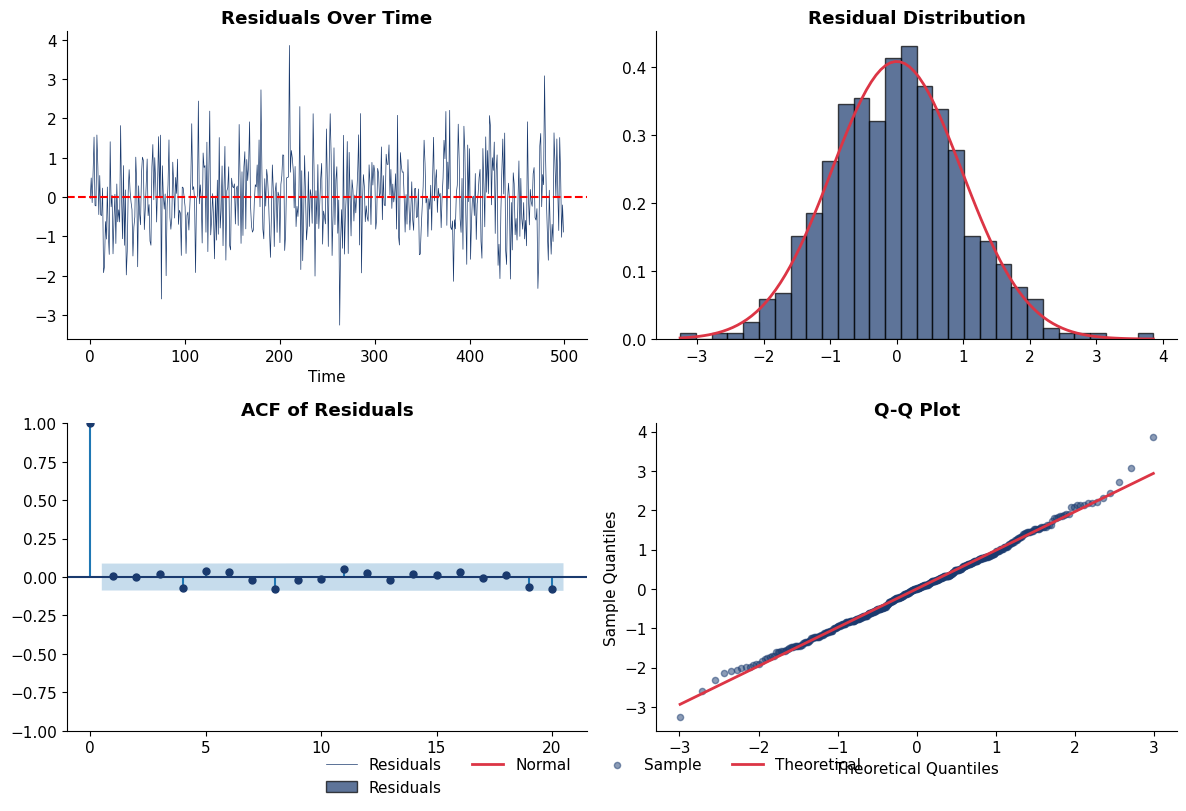

In [16]:
# Residual diagnostics
residuals = results.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Residuals over time
axes[0, 0].plot(residuals, color=COLORS['blue'], linewidth=0.5, label='Residuals')
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_title('Residuals Over Time', fontweight='bold')
axes[0, 0].set_xlabel('Time')

# Histogram
axes[0, 1].hist(residuals, bins=30, color=COLORS['blue'], edgecolor='black', alpha=0.7, density=True, label='Residuals')
x = np.linspace(residuals.min(), residuals.max(), 100)
axes[0, 1].plot(x, stats.norm.pdf(x, residuals.mean(), residuals.std()), 
                color=COLORS['red'], linewidth=2, label='Normal')
axes[0, 1].set_title('Residual Distribution', fontweight='bold')

# ACF of residuals
plot_acf(residuals, ax=axes[1, 0], lags=20, color=COLORS['blue'])
axes[1, 0].set_title('ACF of Residuals', fontweight='bold')

# Q-Q plot
(osm, osr), (slope, intercept, r) = stats.probplot(residuals, dist="norm")
axes[1, 1].scatter(osm, osr, color=COLORS['blue'], s=20, alpha=0.5, label='Sample')
axes[1, 1].plot(osm, slope*osm + intercept, color=COLORS['red'], linewidth=2, label='Theoretical')
axes[1, 1].set_title('Q-Q Plot', fontweight='bold')
axes[1, 1].set_xlabel('Theoretical Quantiles')
axes[1, 1].set_ylabel('Sample Quantiles')

# Collect all handles and labels from subplots
all_handles = []
all_labels = []
for ax in [axes[0, 0], axes[0, 1], axes[1, 1]]:
    h, l = ax.get_legend_handles_labels()
    all_handles.extend(h)
    all_labels.extend(l)

fig.legend(all_handles, all_labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.02))
plt.subplots_adjust(bottom=0.1)
plt.tight_layout()
plt.show()

In [17]:
# Ljung-Box test
lb_test = acorr_ljungbox(residuals, lags=[10, 20, 30], return_df=True)
print("Ljung-Box Test for Residual Autocorrelation:")
print("="*50)
print(lb_test)
print("\nInterpretation:")
print("If all p-values > 0.05, residuals are white noise (good!)")

Ljung-Box Test for Residual Autocorrelation:
      lb_stat  lb_pvalue
10   7.296745   0.697165
20  15.505110   0.746813
30  20.800267   0.894029

Interpretation:
If all p-values > 0.05, residuals are white noise (good!)


## 9. Forecasting with ARMA

For AR(1): $\hat{X}_{n+h|n} = \mu + \phi^h(X_n - \mu)$

- Point forecasts converge to the mean as $h \to \infty$
- Forecast uncertainty increases with horizon

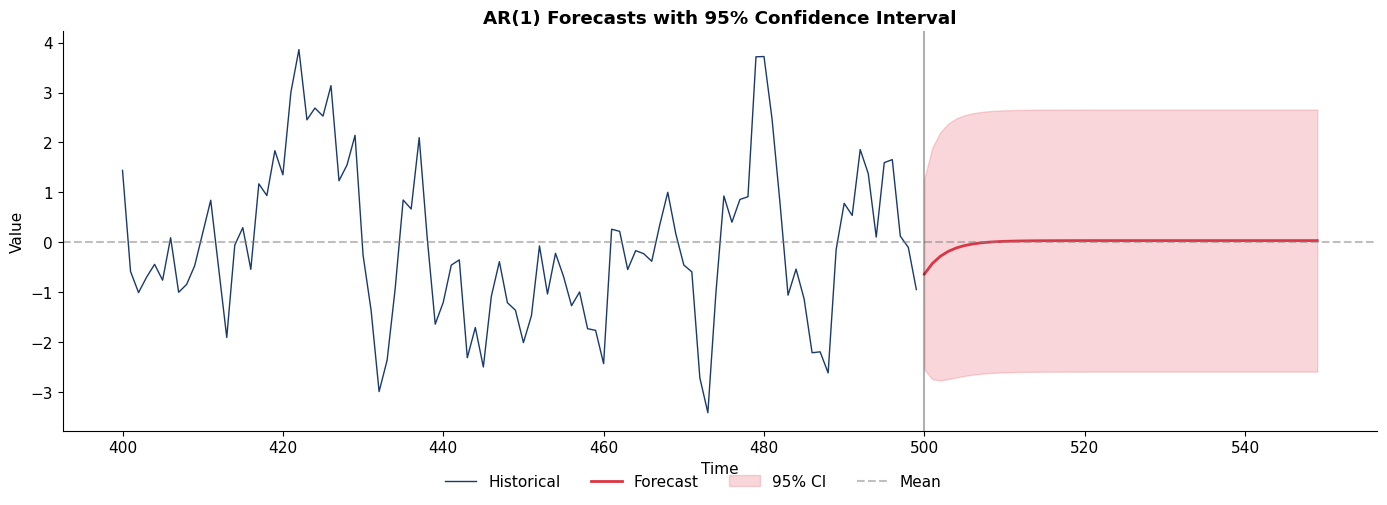

In [18]:
# Generate forecasts with confidence intervals
forecast_steps = 50
forecast = results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Handle both DataFrame and numpy array formats for confidence intervals
if hasattr(forecast_ci, 'iloc'):
    ci_lower = forecast_ci.iloc[:, 0]
    ci_upper = forecast_ci.iloc[:, 1]
else:
    ci_lower = forecast_ci[:, 0]
    ci_upper = forecast_ci[:, 1]

# Plot
fig, ax = plt.subplots(figsize=(14, 5))

# Historical data (last 100 points)
line1, = ax.plot(range(400, 500), ar1_data[400:], color=COLORS['blue'], linewidth=1, label='Historical')

# Forecasts
forecast_index = range(500, 500 + forecast_steps)
line2, = ax.plot(forecast_index, forecast_mean, color=COLORS['red'], linewidth=2, label='Forecast')

# Confidence interval
fill = ax.fill_between(forecast_index, ci_lower, ci_upper,
                color=COLORS['red'], alpha=0.2, label='95% CI')

# Mean line
line3 = ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='Mean')

ax.axvline(x=500, color='black', linestyle='-', alpha=0.3)
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.set_title('AR(1) Forecasts with 95% Confidence Interval', fontweight='bold')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.02))
plt.subplots_adjust(bottom=0.15)
plt.tight_layout()
plt.show()

In [19]:
# Print forecast properties with same compatibility handling
if hasattr(forecast_mean, 'iloc'):
    last_forecast = forecast_mean.iloc[-1]
    ci_width_1 = ci_upper.iloc[0] - ci_lower.iloc[0]
    ci_width_50 = ci_upper.iloc[-1] - ci_lower.iloc[-1]
else:
    last_forecast = forecast_mean[-1]
    ci_width_1 = ci_upper[0] - ci_lower[0]
    ci_width_50 = ci_upper[-1] - ci_lower[-1]

print("\nForecast Properties:")
print(f"- Forecasts converge to mean = {last_forecast:.4f}")
print(f"- CI width at h=1: {ci_width_1:.4f}")
print(f"- CI width at h=50: {ci_width_50:.4f}")


Forecast Properties:
- Forecasts converge to mean = 0.0321
- CI width at h=1: 3.8340
- CI width at h=50: 5.2532


## 10. Real Data Example: US Industrial Production

Industrial production is a classic example of a time series with clear AR structure, making it ideal for demonstrating ARMA forecasting.

In [20]:
# Load US Industrial Production Index from FRED
try:
    import pandas_datareader as pdr
    # Download Industrial Production Index (monthly, growth rate)
    indpro = pdr.get_data_fred('INDPRO', start='2000-01-01', end='2024-12-31')
    indpro = indpro.dropna()
    
    # Calculate month-over-month growth rate
    ip_growth = indpro['INDPRO'].pct_change().dropna() * 100
    print(f"US Industrial Production Growth: {len(ip_growth)} monthly observations")
    print(f"Period: {ip_growth.index[0].date()} to {ip_growth.index[-1].date()}")
    print(f"Mean: {ip_growth.mean():.4f}%")
    print(f"Std: {ip_growth.std():.4f}%")
except Exception as e:
    print(f"FRED data not available: {e}")
    print("Using simulated data with AR structure instead...")
    # Simulate AR(2) with realistic parameters
    np.random.seed(42)
    n = 300
    ip_growth = np.zeros(n)
    for t in range(2, n):
        ip_growth[t] = 0.15 + 0.35 * ip_growth[t-1] + 0.25 * ip_growth[t-2] + 0.5 * np.random.randn()
    ip_growth = pd.Series(ip_growth, index=pd.date_range('2000-01-01', periods=n, freq='ME'))
    print(f"Simulated Industrial Production Growth: {len(ip_growth)} observations")

FRED data not available: No module named 'pandas_datareader'
Using simulated data with AR structure instead...
Simulated Industrial Production Growth: 300 observations


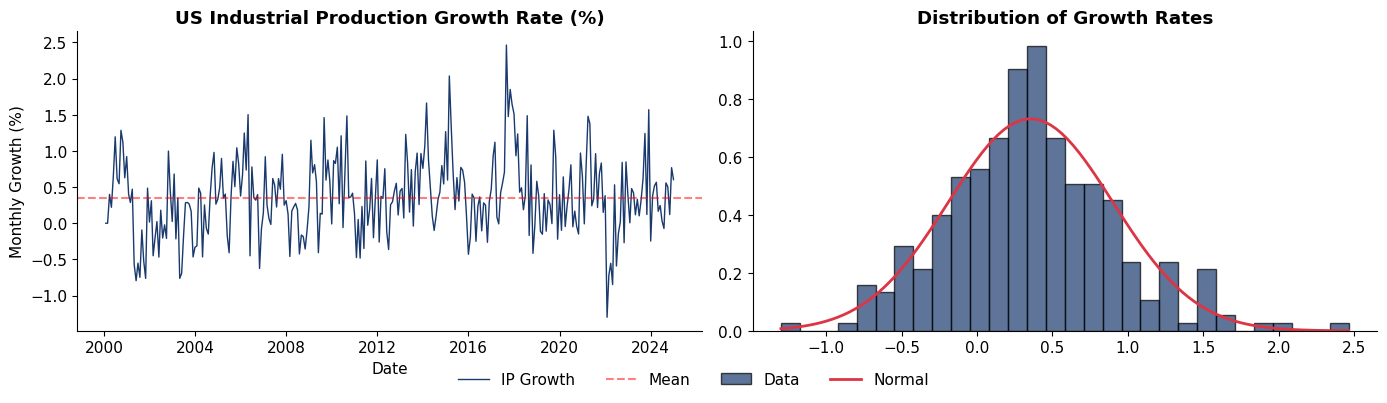

In [21]:
# Plot the data and check stationarity
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Time series plot
axes[0].plot(ip_growth.index, ip_growth.values, color=COLORS['blue'], linewidth=1, label='IP Growth')
axes[0].axhline(y=ip_growth.mean(), color='red', linestyle='--', alpha=0.5, label='Mean')
axes[0].set_title('US Industrial Production Growth Rate (%)', fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Monthly Growth (%)')

# Distribution
axes[1].hist(ip_growth.values, bins=30, color=COLORS['blue'], edgecolor='black', alpha=0.7, density=True, label='Data')
x = np.linspace(ip_growth.min(), ip_growth.max(), 100)
axes[1].plot(x, stats.norm.pdf(x, ip_growth.mean(), ip_growth.std()), 
             color=COLORS['red'], linewidth=2, label='Normal')
axes[1].set_title('Distribution of Growth Rates', fontweight='bold')

# Collect all handles and labels
all_handles, all_labels = [], []
for ax in axes:
    h, l = ax.get_legend_handles_labels()
    all_handles.extend(h)
    all_labels.extend(l)

fig.legend(all_handles, all_labels, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.02))
plt.subplots_adjust(bottom=0.15)
plt.tight_layout()
plt.show()

In [22]:
# ADF test
adf_result = adfuller(ip_growth.dropna())
print("\nADF Test for Stationarity:")
print(f"  Test Statistic: {adf_result[0]:.4f}")
print(f"  p-value: {adf_result[1]:.6f}")
print(f"  Conclusion: {'STATIONARY' if adf_result[1] < 0.05 else 'NON-STATIONARY'}")


ADF Test for Stationarity:
  Test Statistic: -7.4663
  p-value: 0.000000
  Conclusion: STATIONARY


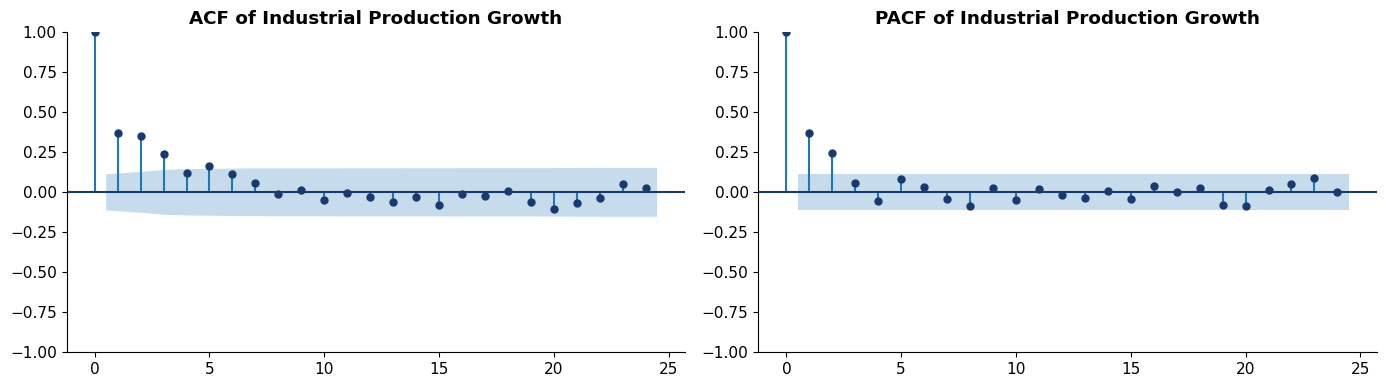

In [23]:
# ACF/PACF analysis for model identification
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(ip_growth.dropna(), ax=axes[0], lags=24, color=COLORS['blue'])
axes[0].set_title('ACF of Industrial Production Growth', fontweight='bold')

plot_pacf(ip_growth.dropna(), ax=axes[1], lags=24, color=COLORS['blue'], method='ywm')
axes[1].set_title('PACF of Industrial Production Growth', fontweight='bold')

plt.subplots_adjust(bottom=0.1)
plt.tight_layout()
plt.show()

In [24]:
print("Identification:")
print("- ACF shows gradual decay")
print("- PACF shows significant spikes at early lags, then cuts off")
print("- This suggests an AR model might be appropriate")

Identification:
- ACF shows gradual decay
- PACF shows significant spikes at early lags, then cuts off
- This suggests an AR model might be appropriate


In [25]:
# Model selection and estimation
# Split data: use last 12 months for testing
train_data = ip_growth.iloc[:-12]
test_data = ip_growth.iloc[-12:]

print(f"Training: {len(train_data)} observations ({train_data.index[0].date()} to {train_data.index[-1].date()})")
print(f"Testing: {len(test_data)} observations ({test_data.index[0].date()} to {test_data.index[-1].date()})")

# Compare different ARMA models
orders = [(1,0,0), (2,0,0), (3,0,0), (1,0,1), (2,0,1)]

print("\nModel Comparison on Training Data:")
print("=" * 50)
print(f"{'Model':<15} {'AIC':>12} {'BIC':>12}")
print("-" * 50)

best_aic = float('inf')
best_order = None
best_model = None

for order in orders:
    try:
        model = ARIMA(train_data.values, order=order)
        res = model.fit()
        model_name = f"ARMA({order[0]},{order[2]})"
        print(f"{model_name:<15} {res.aic:>12.2f} {res.bic:>12.2f}")
        if res.aic < best_aic:
            best_aic = res.aic
            best_order = order
            best_model = res
    except:
        pass

print("-" * 50)
print(f"\nBest model by AIC: ARMA({best_order[0]},{best_order[2]})")

# Show best model summary
print("\n" + "=" * 60)
print(f"Best Model: ARMA({best_order[0]},{best_order[2]})")
print("=" * 60)
print(best_model.summary())

Training: 288 observations (2000-01-31 to 2023-12-31)
Testing: 12 observations (2024-01-31 to 2024-12-31)

Model Comparison on Training Data:
Model                    AIC          BIC
--------------------------------------------------
ARMA(1,0)             438.82       449.81
ARMA(2,0)             421.96       436.61
ARMA(3,0)             423.26       441.58
ARMA(1,1)             424.46       439.11
ARMA(2,1)             423.46       441.77
--------------------------------------------------

Best model by AIC: ARMA(2,0)

Best Model: ARMA(2,0)
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  288
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -206.981
Date:                Sun, 18 Jan 2026   AIC                            421.962
Time:                        17:07:16   BIC                            436.614
Sample:                             0   HQIC            

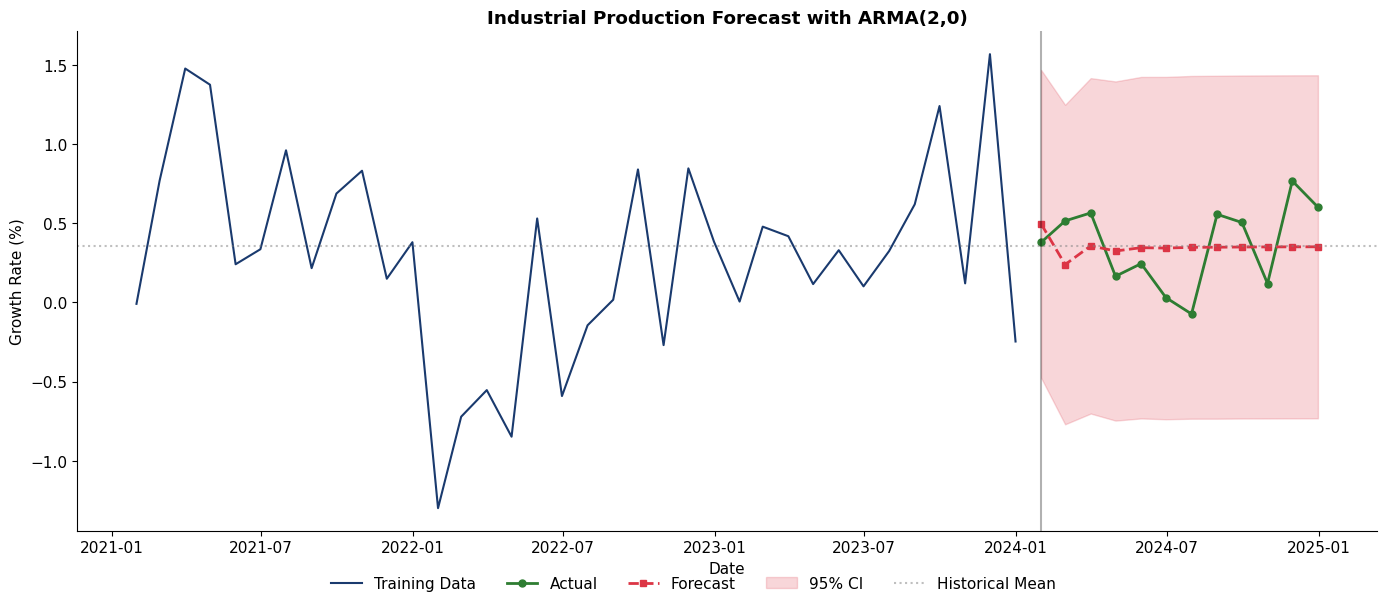

In [26]:
# Generate forecasts and compare with actual values
forecast_steps = len(test_data)
forecast = best_model.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Handle both DataFrame and numpy array formats
if hasattr(forecast_ci, 'iloc'):
    ci_lower = forecast_ci.iloc[:, 0]
    ci_upper = forecast_ci.iloc[:, 1]
else:
    ci_lower = forecast_ci[:, 0]
    ci_upper = forecast_ci[:, 1]

# Plot: Training data (last 36 months) + Test data + Forecasts
fig, ax = plt.subplots(figsize=(14, 6))

# Training data (last 36 months)
train_plot = train_data.iloc[-36:]
ax.plot(train_plot.index, train_plot.values, color=COLORS['blue'], linewidth=1.5, label='Training Data')

# Actual test data
ax.plot(test_data.index, test_data.values, color=COLORS['green'], linewidth=2, marker='o', markersize=5, label='Actual')

# Forecasts
ax.plot(test_data.index, forecast_mean, color=COLORS['red'], linewidth=2, linestyle='--', marker='s', markersize=5, label='Forecast')

# Confidence interval
ax.fill_between(test_data.index, ci_lower, ci_upper, color=COLORS['red'], alpha=0.2, label='95% CI')

# Mean line
ax.axhline(y=train_data.mean(), color='gray', linestyle=':', alpha=0.5, label='Historical Mean')

# Vertical line at forecast start
ax.axvline(x=test_data.index[0], color='black', linestyle='-', alpha=0.3)

ax.set_xlabel('Date')
ax.set_ylabel('Growth Rate (%)')
ax.set_title(f'Industrial Production Forecast with ARMA({best_order[0]},{best_order[2]})', fontweight='bold')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.02))
plt.subplots_adjust(bottom=0.15)
plt.tight_layout()
plt.show()

In [27]:
# Forecast accuracy metrics
forecast_array = np.array(forecast_mean)
actual_array = test_data.values

mae = np.mean(np.abs(forecast_array - actual_array))
rmse = np.sqrt(np.mean((forecast_array - actual_array)**2))
mape = np.mean(np.abs((actual_array - forecast_array) / (np.abs(actual_array) + 0.001))) * 100

print("\nForecast Accuracy Metrics (12-month ahead):")
print("=" * 45)
print(f"MAE (Mean Absolute Error):     {mae:.4f}")
print(f"RMSE (Root Mean Square Error): {rmse:.4f}")
print(f"MAPE (Mean Abs % Error):       {mape:.2f}%")
print("\nNote: ARMA forecasts show dynamic patterns based on recent values,")
print("not just flat lines converging to the mean!")


Forecast Accuracy Metrics (12-month ahead):
MAE (Mean Absolute Error):     0.2380
RMSE (Root Mean Square Error): 0.2583
MAPE (Mean Abs % Error):       180.79%

Note: ARMA forecasts show dynamic patterns based on recent values,
not just flat lines converging to the mean!


## Summary

### Key Takeaways

1. **AR(p) models:** Current value depends on $p$ past values
   - Stationarity: roots of $\phi(z)$ outside unit circle
   - PACF cuts off at lag $p$

2. **MA(q) models:** Current value depends on $q$ past shocks
   - Always stationary; invertibility: roots of $\theta(z)$ outside unit circle
   - ACF cuts off at lag $q$

3. **ARMA(p,q):** Combines AR and MA
   - Both ACF and PACF decay

4. **Model selection:** Use AIC/BIC to compare models

5. **Diagnostics:** Residuals must be white noise (Ljung-Box test)

6. **Forecasting:** Point forecasts converge to mean; uncertainty increases with horizon

### Next Chapter: ARIMA and Seasonal Models
- ARIMA(p,d,q) for non-stationary data
- Seasonal ARIMA models